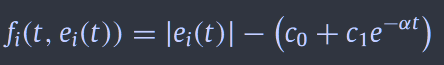

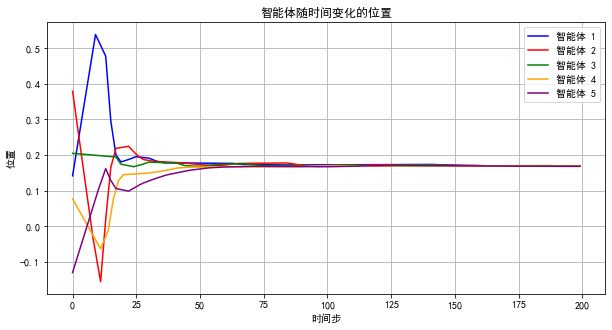

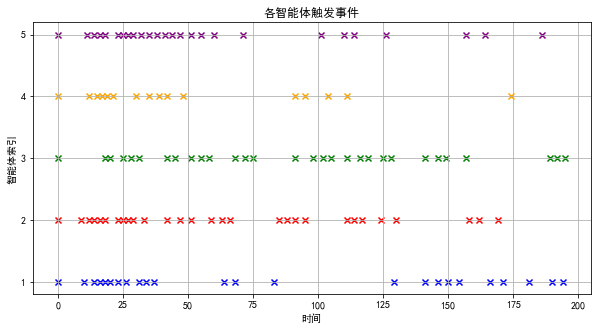

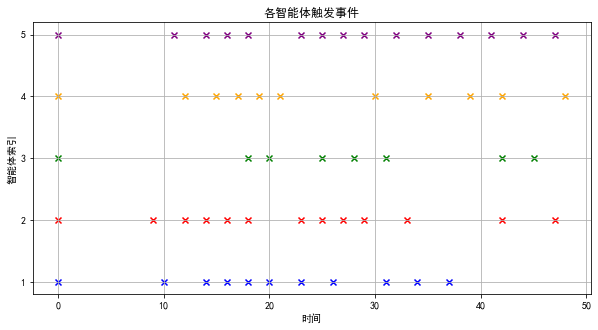

In [64]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.4669
        self.si = 0.001
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        mu = (self.si + (1 - self.si) * (1 - np.exp(-self.si * t)))
        trigger_condition = mu * np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
        else:
            self.position += self.u_i * dt
            

# 初始化参数和智能体
num_agents = 5
num_iterations = 200
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]


# 运行模拟
positions = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position


# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}', color=colors[i])
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)
plt.show()



# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 创建自定义的时间数组
time = 50
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((custom_time[t], i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()




'''plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
    # 绘制事件触发点
    if agent.trigger_points:
        trigger_times, trigger_positions = zip(*agent.trigger_points)
        plt.scatter(trigger_times, trigger_positions, marker='x', label=f'智能体 {i + 1} 触发点')
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)'''


# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()

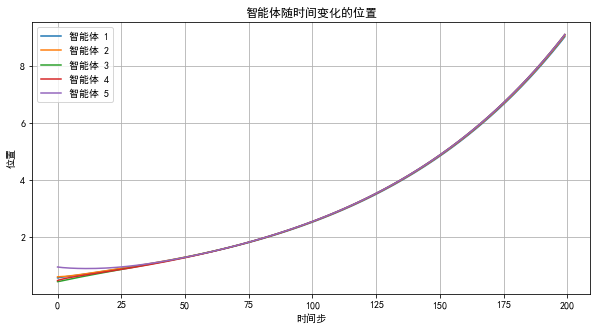

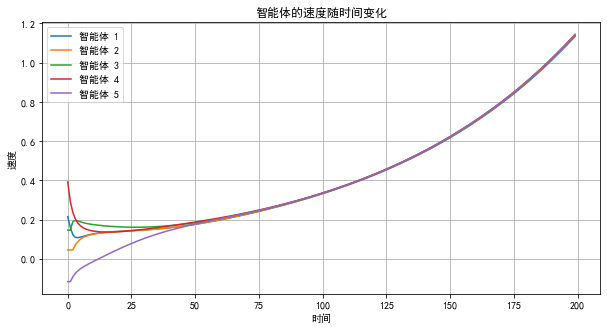

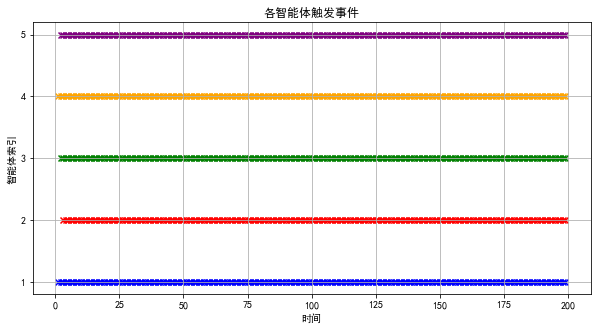

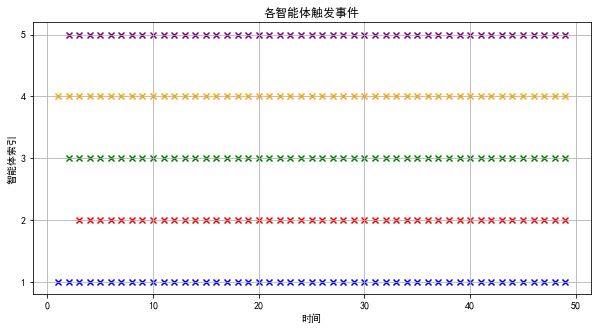

In [65]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, initial_velocity, index):
        self.position = initial_position
        self.velocity = initial_velocity
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.last_broadcast_velocity = self.velocity
        self.trigger_points = []
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.4669
        self.mu = 2
        self.last_event_time = 0  # 初始化上一次事件触发的时间为0
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    
    def update_position(self, t, dt):
        time_since_last_event = t - self.last_event_time
        estimated_position = self.last_broadcast_position + time_since_last_event * self.last_broadcast_velocity
        position_error = estimated_position - self.position
        e_i_velocity = self.last_broadcast_velocity - self.velocity
        trigger_condition = np.linalg.norm([position_error, self.mu * e_i_velocity]) - (self.c_0 + self.c_1 * np.exp(-self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0:
            u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors) \
                - self.mu * sum(self.is_neighbor(neighbor) * (self.last_broadcast_velocity - neighbor.last_broadcast_velocity) for neighbor in self.neighbors)

            self.velocity += u_i * dt
            self.last_broadcast_position = self.position
            self.last_broadcast_velocity = self.velocity
            self.last_event_time = t
            #记录触发的相关信息
            self.trigger_points.append((t, self.velocity))

        self.position += self.velocity * dt
        #print(- sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors))
        #print(- self.mu * sum(self.is_neighbor(neighbor) * (self.last_broadcast_velocity - neighbor.last_broadcast_velocity) for neighbor in self.neighbors))
        #print()



# 初始化参数和智能体
num_agents = 5
num_iterations = 200
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.uniform(0, 1), np.random.uniform(-0.5, 0.5), i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]


# 运行模拟
positions = np.zeros((num_iterations, num_agents))
velocities = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position
        velocities[t, agent.index] = agent.velocity

colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色
# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(velocities[:, i], label=f'智能体 {i+1}')
plt.xlabel('时间')
plt.ylabel('速度')
plt.title('智能体的速度随时间变化')
plt.legend()
plt.grid(True)


# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 创建自定义的时间数组
time = 50
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((custom_time[t], i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()